# Conflict in clinical significance in ClinVar 

Importing libraries

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import os as os 
import time as time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import balanced_accuracy_score,accuracy_score, roc_auc_score, make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

## Reading data 

In [2]:
# main dataset
df = pd.read_csv("finalClin_3.csv", encoding='latin-1')
# Validation dataset
vdf = pd.read_csv("val_df.csv", encoding='latin-1')
#Production (Single submitter) dataset
ss = pd.read_csv("ss_df_2.csv", encoding='latin-1')

print("main data frame" ,df.shape)
print("validation data frame", vdf.shape)
print("single submitter data frame", ss.shape)

main data frame (187493, 50)
validation data frame (28993, 50)
single submitter data frame (690455, 50)


In [3]:
#dataframes concatenation
l = [df,vdf, ss]
df = pd.concat(l, ignore_index = True)
df.shape

(906941, 50)

In [4]:
# see df head
df.head()

,class,ID,SYMBOL,Allele,CLNVC,Consequence,IMPACT,relativeLocationRatio,ExIntron,Protein_position,...,H1.hESC_confidence_value,HUVEC_confidence_value,SiPhy_29way_logOdds,bStatistic,phastCons100way_vertebrate,GM12878_fitCons_rankscore,H1.hESC_fitCons_rankscore,HUVEC_fitCons_rankscore,phyloP30way_mammalian_rankscore,EVE_scores_ASM
0,0.0,659187,ISG15,G>A,single_nucleotide_variant,missense_variant,MODERATE,1.000000,2.0,44,...,0.0,0.0,3.4880,929.0,0.122,0.09955,0.31042,0.5714,0.04913,NaN
1,0.0,402986,ISG15,G>A,single_nucleotide_variant,missense_variant,MODERATE,1.000000,2.0,83,...,0.0,0.0,9.9720,929.0,0.000,0.09955,0.31042,0.5714,0.01748,NaN
2,0.0,571208,ISG15,G>A,single_nucleotide_variant,missense_variant,MODERATE,1.000000,2.0,92,...,0.0,0.0,6.5244,929.0,0.000,0.09955,0.31042,0.5714,0.12110,NaN
3,0.0,568195,ISG15,G>A,single_nucleotide_variant,missense_variant,MODERATE,1.000000,2.0,99,...,0.0,0.0,3.5096,929.0,0.000,0.09955,0.31042,0.5714,0.00043,NaN
4,0.0,387476,AGRN,G>C,single_nucleotide_variant,missense_variant,MODERATE,0.027778,1.0,4,...,0.0,1.0,2.0859,934.0,0.000,0.04544,0.10781,0.0843,0.01906,NaN


In [5]:
# checking type of variables
df.dtypes

class                                 float64
ID                                      int64
SYMBOL                                 object
Allele                                 object
CLNVC                                  object
Consequence                            object
IMPACT                                 object
relativeLocationRatio                 float64
ExIntron                              float64
Protein_position                       object
Codons                                 object
TSL                                   float64
Denisova                               object
SIFT                                  float64
PolyPhen                              float64
firstSubmitter                         object
submitterNo                             int64
CollectionMethod                       object
CADD_raw_rankscore_hg19               float64
ClinPred_rankscore                    float64
DANN_rankscore                        float64
Eigen.raw_coding_rankscore        

In [6]:
# dropping columns no longer needed
df = df.drop(['ID', 'Protein_position', 'Codons'], axis = 1).copy()


### Calculate missing values percentage in the dataset

In [7]:
# calculate missing values percentage in the dataset
num_missing = df.isnull().sum()
percentage_missing = df.isnull().sum().apply(lambda x: x/df.shape[0]*100)

missing_data = pd.DataFrame({'Number of Missing':  num_missing,
                             'Percentage of Missing': percentage_missing})

missing_data['Percentage of Missing'].sort_values(ascending = False)

EVE_scores_ASM                        86.367911
AF_TGP                                83.100996
gnomAD_genomes_NFE_AN                 79.525901
gnomAD_genomes_AFR_AF                 79.525901
gnomAD_exomes_controls_NFE_AN         77.704944
class                                 76.130090
AF                                    74.924719
MutationAssessor_rankscore            64.950642
MPC_rankscore                         64.503204
M.CAP_rankscore                       62.856128
LIST.S2_rankscore                     62.268659
FATHMM_converted_rankscore            61.956511
LRT_converted_rankscore               61.727499
SIFT                                  61.646788
MetaSVM_rankscore                     61.276092
ClinPred_rankscore                    61.161200
PolyPhen                              60.710785
fathmm.XF_coding_rankscore            60.556420
Eigen.raw_coding_rankscore            60.392903
H1.hESC_confidence_value              60.149999
GM12878_confidence_value              60

### Counting unique values
To obtain ideas on each variable in the data. Numeric variable can be distinguished by high level of unique value in data.

In [8]:
pd.DataFrame([[i, len(df[i].unique())] for i in df.columns],
             columns=['Variable', 'Unique Values']).set_index('Variable')

,Unique Values
Variable,
class,3
SYMBOL,3812
Allele,14
CLNVC,7
Consequence,75
IMPACT,4
relativeLocationRatio,7307
ExIntron,365
TSL,6


### defining predictors and response variables

In [9]:
X = df.drop('class', axis = 1).copy()
X.head()

,SYMBOL,Allele,CLNVC,Consequence,IMPACT,relativeLocationRatio,ExIntron,TSL,Denisova,SIFT,...,H1.hESC_confidence_value,HUVEC_confidence_value,SiPhy_29way_logOdds,bStatistic,phastCons100way_vertebrate,GM12878_fitCons_rankscore,H1.hESC_fitCons_rankscore,HUVEC_fitCons_rankscore,phyloP30way_mammalian_rankscore,EVE_scores_ASM
0,ISG15,G>A,single_nucleotide_variant,missense_variant,MODERATE,1.000000,2.0,NaN,G/G,0.10,...,0.0,0.0,3.4880,929.0,0.122,0.09955,0.31042,0.5714,0.04913,NaN
1,ISG15,G>A,single_nucleotide_variant,missense_variant,MODERATE,1.000000,2.0,NaN,A/A,0.38,...,0.0,0.0,9.9720,929.0,0.000,0.09955,0.31042,0.5714,0.01748,NaN
2,ISG15,G>A,single_nucleotide_variant,missense_variant,MODERATE,1.000000,2.0,NaN,G/G,0.13,...,0.0,0.0,6.5244,929.0,0.000,0.09955,0.31042,0.5714,0.12110,NaN
3,ISG15,G>A,single_nucleotide_variant,missense_variant,MODERATE,1.000000,2.0,NaN,G/G,0.87,...,0.0,0.0,3.5096,929.0,0.000,0.09955,0.31042,0.5714,0.00043,NaN
4,AGRN,G>C,single_nucleotide_variant,missense_variant,MODERATE,0.027778,1.0,1.0,G/G,0.12,...,0.0,1.0,2.0859,934.0,0.000,0.04544,0.10781,0.0843,0.01906,NaN


In [10]:
y = df['class'].copy()
y.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: class, dtype: float64

### One-hot encoding

In [11]:
print("One-Hot Encoding")
X_encoded = pd.get_dummies(X, columns=['SYMBOL',
                                       'Allele',
                                       'CLNVC',
                                       'Consequence',
                                       'IMPACT',
                                       'CollectionMethod',
                                       'Denisova',
                                       'TSL',
                                       'firstSubmitter'])
X_encoded.head()

One-Hot Encoding


,relativeLocationRatio,ExIntron,SIFT,PolyPhen,submitterNo,CADD_raw_rankscore_hg19,ClinPred_rankscore,DANN_rankscore,Eigen.raw_coding_rankscore,LIST.S2_rankscore,...,firstSubmitter_UNCMolecularGeneticsLaboratoryUnive,firstSubmitter_UWHindbrainMalformationResearchProg,firstSubmitter_UndiagnosedDiseasesNetworkNIH,firstSubmitter_UnitforGeneticEpidemiologicalResear,firstSubmitter_UniversityofWashingtonCenterforMend,firstSubmitter_UniversityofWashingtonDepartmentofL,firstSubmitter_VictorianClinicalGeneticsServicesMu,firstSubmitter_WomensHealthandGeneticsLaboratoryCo,firstSubmitter_WongMitoLabMolecularandHumanGenetic,firstSubmitter_other
0,1.000000,2.0,0.10,0.952,2,0.38964,0.15687,0.89085,0.38367,0.33984,...,0,0,0,0,0,0,0,0,0,0
1,1.000000,2.0,0.38,0.003,3,0.06002,0.00038,0.15196,0.03563,0.14579,...,0,0,0,0,0,0,0,0,0,0
2,1.000000,2.0,0.13,0.115,2,0.15404,0.19137,0.44442,0.16641,0.34650,...,0,0,0,0,0,0,0,0,0,0
3,1.000000,2.0,0.87,0.001,2,0.00104,0.00179,0.11246,0.00039,0.12095,...,0,0,0,0,0,0,0,0,0,0
4,0.027778,1.0,0.12,0.000,2,0.12689,0.00050,0.00769,0.02306,0.05533,...,0,0,0,0,0,0,0,0,0,0


### seprating Validation dataset from the X and y

In [12]:
print("orginal validation set dimention", vdf.shape)

# X_val
X_val = pd.DataFrame(X_encoded.loc[187494:216486])
#X_val.head()
print(X_val.shape)

type(y)

y_val = y.iloc[187493:216486]
print(y_val.shape)

#ss dataframe
sX = pd.DataFrame(X_encoded.loc[216486:])
print(sX.shape)

# now reverting X and y to their orginal shape
X_encoded = pd.DataFrame(X_encoded.loc[:187492])
#X_val.head()
print(X_encoded.shape)

y = y.iloc[:187493]
print(y.shape)



orginal validation set dimention (28993, 50)
(28993, 4123)
(28993,)
(690455, 4123)
(187493, 4123)
(187493,)


In [13]:
# changing data type for ys:
y.astype('int64').dtypes
print(y.dtypes)
y_val.astype('int64').dtypes
print(y_val.dtypes)

float64
float64


### Basci Model

In [14]:
# checking precent of diffrent class
sum(y)/len(y)

0.26144442725861766

In [15]:
# so lets stratify by y
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state = 42, stratify=y)


In [16]:
# # verify using stratify worked as expected
sum(y_train)/len(y_train)

0.26144404383475917

In [17]:
sum(y_test)/len(y_test)

0.26144557750565345

In [18]:
# making classifier
clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic',
                            seed =42,
                            n_estimators=500)

# define the eval set and metric
eval_set = [(X_test, y_test)]
eval_metric = ["aucpr","error"]

%time clf_xgb.fit(X_train, y_train, verbose = True, early_stopping_rounds = 10, eval_metric= eval_metric, eval_set=eval_set)

C:\Users\qaedi\anaconda3\envs\xgboost_env\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-aucpr:0.60232	validation_0-error:0.20361
[1]	validation_0-aucpr:0.62628	validation_0-error:0.20084
[2]	validation_0-aucpr:0.62972	validation_0-error:0.19945
[3]	validation_0-aucpr:0.64011	validation_0-error:0.19668
[4]	validation_0-aucpr:0.64502	validation_0-error:0.19653
[5]	validation_0-aucpr:0.64938	validation_0-error:0.19499
[6]	validation_0-aucpr:0.65237	validation_0-error:0.19422
[7]	validation_0-aucpr:0.65512	validation_0-error:0.19358
[8]	validation_0-aucpr:0.65739	validation_0-error:0.19281
[9]	validation_0-aucpr:0.65956	validation_0-error:0.19256
[10]	validation_0-aucpr:0.66400	validation_0-error:0.19228
[11]	validation_0-aucpr:0.66866	validation_0-error:0.19083
[12]	validation_0-aucpr:0.67072	validation_0-error:0.19064
[13]	validation_0-aucpr:0.67312	validation_0-error:0.18955
[14]	validation_0-aucpr:0.67359	validation_0-error:0.18912
[15]	validation_0-aucpr:0.67391	validation_0-error:0.18889
[16]	validation_0-aucpr:0.67581	validation_0-error:0.18812
[17]	va

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=16, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [19]:
#Model assessment
pred_test = clf_xgb.predict(X_test)
pred_train = clf_xgb.predict(X_train)
print('Train Accuracy: ', accuracy_score(y_train, pred_train))
print('Test Accuraccy: ', accuracy_score(y_test, pred_test))
print('Classification Report:')
print(classification_report(y_test,pred_test))

Train Accuracy:  0.8227266585596541
Test Accuraccy:  0.8174041046208986
Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.94      0.88     34619
         1.0       0.74      0.47      0.57     12255

    accuracy                           0.82     46874
   macro avg       0.78      0.71      0.73     46874
weighted avg       0.81      0.82      0.80     46874



plotting the performance


C:\Users\qaedi\anaconda3\envs\xgboost_env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


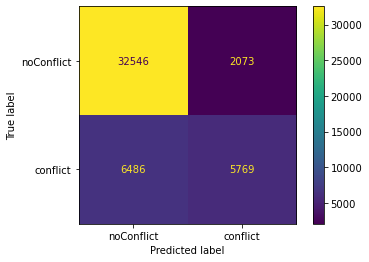

In [20]:
print('plotting the performance')
#
clf_xgb2 = clf_xgb

plot_confusion_matrix(clf_xgb2,
                     X_test,
                     y_test,
                     values_format = 'd',
                     display_labels = ['noConflict', 'conflict'])
#plt.savefig('confMat_with_EVE.png') 

### Hyper-parameters tuning Using Hyperopt library

Defining the value for 'scale_pos_weight': number of negative cases (majority group) / number of positive cases (minority group)
    scale_pos_weight = 138474/49019 = 2.82

In [22]:
# space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
#         'gamma': hp.uniform ('gamma', 1,9),
#         'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
#         'reg_lambda' : hp.uniform('reg_lambda', 0,1),
#         'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
#         'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
#         'n_estimators': 180,
#         'seed': 0
#     }

param_grid  = {
    'learning_rate': [0.1, 0.3, 0.5],
    'gamma': [0,1,2],
    'reg_lambda' : [0,1.0,10.0],
    'scale_pos_weight' : [1,3,5]
}


space={'gamma':hp.uniform ('gamma', 0,9),
        'learning_rate': hp.uniform('learning_rate', 0.1, 0.8),
        'scale_pos_weight': hp.uniform('scale_pos_weight', 1, 5),
        'reg_lambda': hp.uniform('reg_lambda', 1.0, 10.0),                       
    }

In [23]:
def objective(space):
    clf=xgb.XGBClassifier(
                    gamma = space['gamma'],
                    learning_rate = space['learning_rate'],
                    reg_lambda = space['reg_lambda'],
                    use_label_encoder=False ,
                    seed = 42,
                    scale_pos_weight = space['scale_pos_weight'],
                    n_estimators = 500)
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="aucpr",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [ ]:
# This will take ~12 h. Result is in the next cell but commented. 
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

In [ ]:
# SCORE:                                                 
# 0.8130946793531595                                     
# SCORE:                                                                               
# 0.8153560609292998                                                                   
# SCORE:                                                                               
# 0.8118573196228186                                                                   
# SCORE:                                                                               
# 0.7310449289584845                                                                   
# SCORE:                                                                               
# 0.735567692110765                                                                    
# SCORE:                                                                               
# 0.7185646627128045                                                                   
# SCORE:                                                                                
# 0.7664376840039254                                                                    
# SCORE:                                                                                
# 0.8155267312369331                                                                    
# SCORE:                                                                                
# 0.7395357767632376                                                                      
# SCORE:                                                                                  
# 0.7484959679139822                                                                      
# SCORE:                                                                                   
# 0.7465332593762001                                                                       
# SCORE:                                                                                   
# 0.749178649144515                                                                        
# SCORE:                                                                                   
# 0.748751973375432                                                                        
# SCORE:                                                                                   
# 0.771941801425097                                                                        
# SCORE:                                                                                   
# 0.7165379528096599                                                                      
# SCORE:                                                                                  
# 0.8037718137986943                                                                      
# SCORE:                                                                                  
# 0.7212527200580279                                                                      
# SCORE:                                                                                  
# 0.7563468020651107                                                                      
# SCORE:                                                                                  
# 0.7401971242053164                                                                      
# SCORE:                                                                                   
# 0.8168494261210906                                                                       
# SCORE:                                                                                   
# 0.7889021632461493                                                                       
# SCORE:                                                                                   
# 0.7876221359389001                                                                       
# SCORE:                                                                                   
# 0.8023424499722661                                                                      
# SCORE:                                                                                  
# 0.8172334343132653                                                                      
# SCORE:                                                                                  
# 0.8171480991594487                                                                      
# SCORE:                                                                                  
# 0.8084225796816998                                                                      
# SCORE:                                                                                  
# 0.8170840977940863                                                                      
# SCORE:                                                                                  
# 0.7785339420574305                                                                      
# SCORE:                                                                                  
# 0.7876434697273542                                                                      
# SCORE:                                                                                  
# 0.8167854247557281                                                                      
# SCORE:                                                                                  
# 0.8165294192942782                                                                      
# SCORE:                                                                                  
# 0.8108546315654734                                                                      
# SCORE:                                                                                  
# 0.7961983188974698                                                                      
# SCORE:                                                                                  
# 0.8116013141613688                                                                      
# SCORE:                                                                                  
# 0.8170840977940863                                                                      
# SCORE:                                                                                  
# 0.7797713017877714                                                                      
# SCORE:                                                                                  
# 0.750288006144131                                                                       
# SCORE:                                                                                  
# 0.7079831036395443                                                                      
# SCORE:                                                                                  
# 0.815932073217562                                                                       
# SCORE:                                                                                  
# 0.8142040363527755                                                                      
# SCORE:                                                                                  
# 0.7092417971583393                                                                      
# SCORE:                                                                                  
# 0.808571916200879                                                                       
# SCORE:                                                                                  
# 0.798438366685156                                                                       
# SCORE:                                                                                  
# 0.7849980799590391                                                                      
# SCORE:                                                                                  
# 0.7731578273669838                                                                      
# SCORE:                                                                                  
# 0.8173827708324444                                                                      
# SCORE:                                                                                  
# 0.7618722532747365                                                                      
# SCORE:                                                                                   
# 0.8131373469300679                                                                       
# SCORE:                                                                                   
# 0.7292315569398814                                                                      
# SCORE:                                                                                  
# 0.8036224772795153                                                                      
# SCORE:                                                                                  
# 0.8157187353330204                                                                      
# SCORE:                                                                                  
# 0.8127106711609847                                                                      
# SCORE:                                                                                  
# 0.7416264880317447                                                                      
# SCORE:                                                                                  
# 0.7812433331911081                                                                      
# SCORE:                                                                                  
# 0.7222554081153731                                                                      
# SCORE:                                                                                  
# 0.7887741605154244                                                                      
# SCORE:                                                                                  
# 0.8104919571617528                                                                      
# SCORE:                                                                                  
# 0.7591841959295131                                                                      
# SCORE:                                                                                  
# 0.7746085249818663                                                                      
# SCORE:                                                                                  
# 0.7839740581132397                                                                      
# SCORE:                                                                                  
# 0.8161454111021035                                                                      
# SCORE:                                                                                  
# 0.7474719460681828                                                                      
# SCORE:                                                                                  
# 0.7640269659086061                                                                      
# SCORE:                                                                                  
# 0.8122199940265392                                                                      
# SCORE:                                                                                  
# 0.748602636856253                                                                       
# SCORE:                                                                                  
# 0.8184281264666979                                                                      
# SCORE:                                                                                  
# 0.796368989205103                                                                       
# SCORE:                                                                                  
# 0.8146733796987669                                                                      
# SCORE:                                                                                  
# 0.8180441182745232                                                                      
# SCORE:                                                                                  
# 0.80677987797073                                                                        
# SCORE:                                                                                  
# 0.8132013482954303                                                                      
# SCORE:                                                                                  
# 0.8162520800443743                                                                      
# SCORE:                                                                                  
# 0.8146307121218586                                                                      
# SCORE:                                                                                  
# 0.8179801169091607                                                                      
# SCORE:                                                                                  
# 0.8184067926782438                                                                      
# SCORE:                                                                                  
# 0.8176174425054401                                                                      
# SCORE:                                                                                  
# 0.7866621154584631                                                                      
# SCORE:                                                                                  
# 0.8133506848146094                                                                      
# SCORE:                                                                                  
# 0.7997823953577676                                                                      
# SCORE:                                                                                  
# 0.7930835857831634                                                                      
# SCORE:                                                                                  
# 0.813158680718522                                                                       
# SCORE:                                                                                  
# 0.8009130861458378                                                                      
# SCORE:                                                                                  
# 0.8158680718521996                                                                      
# SCORE:                                                                                  
# 0.8177027776592567                                                                      
# SCORE:                                                                                  
# 0.7329436361309041                                                                      
# SCORE:                                                                                  
# 0.7926782438025345                                                                      
# SCORE:                                                                                  
# 0.8103426206425737                                                                      
# SCORE:                                                                                  
# 0.7304475828817681                                                                      
# SCORE:                                                                                  
# 0.8014890984340999                                                                       
# SCORE:                                                                                   
# 0.8080812390664334                                                                       
# SCORE:                                                                                   
# 0.7552587788539489                                                                       
# SCORE:                                                                                   
# 0.7753338737893075                                                                       
# SCORE:                                                                                   
# 0.8174467721978069                                                                       
# SCORE:                                                                                   
# 0.7181806545206297                                                                     
# SCORE:                                                                                 
# 0.7966676622434612                                                                     
# SCORE:                                                                                 
# 0.8142680377181379                                                                     
# SCORE:                                                                                 
# 0.8182574561590648                                                                     
# SCORE:                                                                                 
# 0.7912915475530145                                                                     
# SCORE:                                                                                 
# 0.8195801510432222                                                                     
# SCORE:                                                                                 
# 0.8072918888936297                                                                     
# 100%|██████████| 100/100 [11:34:21<00:00, 416.62s/trial, best loss: -0.8195801510432222]
# ​

In [ ]:
print(best_hyperparams)

The best hyperparameters are :  

{'gamma': 3.6515303677736166, 'learning_rate': 0.24633323285520856, 'reg_lambda': 6.219346093199228, 'scale_pos_weight': 1.22040601122064}

### Best model performance

In [18]:
# Classifer based on hyperopt library
clf_xgb = xgb.XGBClassifier(seed=42,
                            objective = 'binary:logistic',
                            gamma = 3.65,
                            reg_lambda = 6.219,
                            learning_rate = 0.246,
                            max_depth = 6,
                            scale_pos_weight =  1.22,
                            subsample = 0.9,
                            colsample_bytree = 0.5,
                            n_estimators=500,
                            use_label_encoder=False)
eval_set = [(X_test, y_test)]
eval_metric = ["aucpr","error"]

clf_xgb.fit(X_train,
            y_train,
            verbose = True,
            early_stopping_rounds  =10,
            eval_metric = eval_metric,
            eval_set = eval_set)



[0]	validation_0-aucpr:0.51215	validation_0-error:0.23491
[1]	validation_0-aucpr:0.61939	validation_0-error:0.19953
[2]	validation_0-aucpr:0.62575	validation_0-error:0.19704
[3]	validation_0-aucpr:0.62814	validation_0-error:0.19698
[4]	validation_0-aucpr:0.63257	validation_0-error:0.19646
[5]	validation_0-aucpr:0.63758	validation_0-error:0.19589
[6]	validation_0-aucpr:0.64399	validation_0-error:0.19514
[7]	validation_0-aucpr:0.64804	validation_0-error:0.19399
[8]	validation_0-aucpr:0.65159	validation_0-error:0.19339
[9]	validation_0-aucpr:0.65392	validation_0-error:0.19301
[10]	validation_0-aucpr:0.65702	validation_0-error:0.19185
[11]	validation_0-aucpr:0.65922	validation_0-error:0.19177
[12]	validation_0-aucpr:0.66025	validation_0-error:0.19164
[13]	validation_0-aucpr:0.66192	validation_0-error:0.19107
[14]	validation_0-aucpr:0.66226	validation_0-error:0.19087
[15]	validation_0-aucpr:0.66368	validation_0-error:0.19051
[16]	validation_0-aucpr:0.66526	validation_0-error:0.19010
[17]	va

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=3.65, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.246, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=16, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=6.219, scale_pos_weight=1.22, seed=42,
              subsample=0.9, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [19]:
# best model assessment
pred_test = clf_xgb.predict(X_test)
pred_train = clf_xgb.predict(X_train)
print('Train Accuracy: ', accuracy_score(y_train, pred_train))
print('Test Accuraccy: ', accuracy_score(y_test, pred_test))
print('Classification Report:')
print(classification_report(y_test,pred_test))

Train Accuracy:  0.8247889687737788
Test Accuraccy:  0.8182787899475189
Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.92      0.88     34619
         1.0       0.70      0.53      0.60     12255

    accuracy                           0.82     46874
   macro avg       0.78      0.72      0.74     46874
weighted avg       0.81      0.82      0.81     46874



### performance on the validation set

In [20]:
# final model assessment
pred_val = clf_xgb.predict(X_val)
pred_train = clf_xgb.predict(X_train)
print('Train Accuracy: ', accuracy_score(y_train, pred_train))
print('Validation test accuraccy: ', accuracy_score(y_val, pred_val))
print('Classification Report:')
print(classification_report(y_val,pred_val))

Train Accuracy:  0.8247889687737788
Validation test accuraccy:  0.8703825061221674
Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.97      0.93     25831
         1.0       0.16      0.04      0.07      3162

    accuracy                           0.87     28993
   macro avg       0.53      0.51      0.50     28993
weighted avg       0.81      0.87      0.84     28993



In [38]:
# final model assessment
pred_val = clf_xgb.predict(X_val)
pred_train = clf_xgb.predict(X_train)
print('Train Accuracy: ', accuracy_score(y_train, pred_train))
print('Validation test accuraccy: ', accuracy_score(y_val, pred_val))
print('Classification Report:')
print(classification_report(y_val,pred_val))



Train Accuracy:  0.8247889687737788
Validation test accuraccy:  0.881626599524023
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94     25831
           1       0.35      0.10      0.15      3162

    accuracy                           0.88     28993
   macro avg       0.62      0.54      0.54     28993
weighted avg       0.84      0.88      0.85     28993



### Feature importance

In [21]:
# store the winning model in a new variable
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns # for correlation heatmap

In [22]:
xgc = clf_xgb.feature_importances_
#xgc.size
# 4123 > this should be equal to the X_encoded dataset column mumber
#len(X_encoded.columns.values.tolist())
#4123

# making a dataframe from column names and FI
fimp = pd.DataFrame(data=xgc, index= X_encoded.columns.values.tolist())
# assigning colum name to the first column
fimp.rename(columns={fimp.columns[0]: "XGBoost_Feature_Importance" }, inplace = True)
fimp.sort_values('XGBoost_Feature_Importance', ascending=False, inplace=True)
# calsulate colSums
#fimp.iloc[:,0].sum()
1.0000001
# visualizing first 20 rows
fimp.head(n = 20)
# sclicing the dataframe
fimp_sliced = fimp.head(n = 20)
fimp_sliced.sort_values('XGBoost_Feature_Importance', ascending=True, inplace=True)

C:\Users\qaedi\anaconda3\envs\xgboost_env\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


plotting the performance


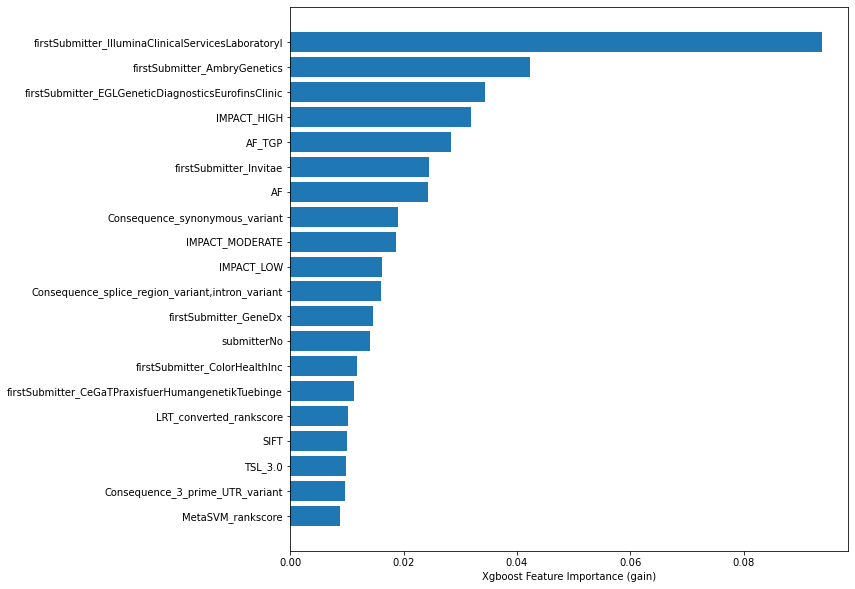

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
plt.barh(list(fimp_sliced.index), fimp_sliced['XGBoost_Feature_Importance'])
plt.xlabel("Xgboost Feature Importance (gain)")
#plt.savefig('xgboost_feature_importance.png')
#plt.savefig('xgboost_feature_importance.png', bbox_inches='tight', dpi=300)

print('plotting the performance')
# plot_confusion_matrix(clf_xgb,
#                      X_test,
#                      y_test,
#                      values_format = 'd',
#                      display_labels = ['noConflict', 'conflict'])

# fig, (ax1, ax2) = plt.subplots(1, 2)
# fig.suptitle('XGBoost performance metrics')
# ax1.plot(x, y)
# ax2.plot(x, -y)

#plt.savefig('feature_importance_only_gain.png', bbox_inches='tight') 

To plot the global feature importance we can use the 'plot_importances' method. It is possible to specify one of three metrics to calculate the individual feature scores:

Feature Weights: the score is calculated based on the number of times the feature appears in the trees

Gain: the score is calculated based on the average gain of splits which use the feature

Coverage: the score is calculated based on the average coverage (number of samples affected by the split) of splits which use the feature

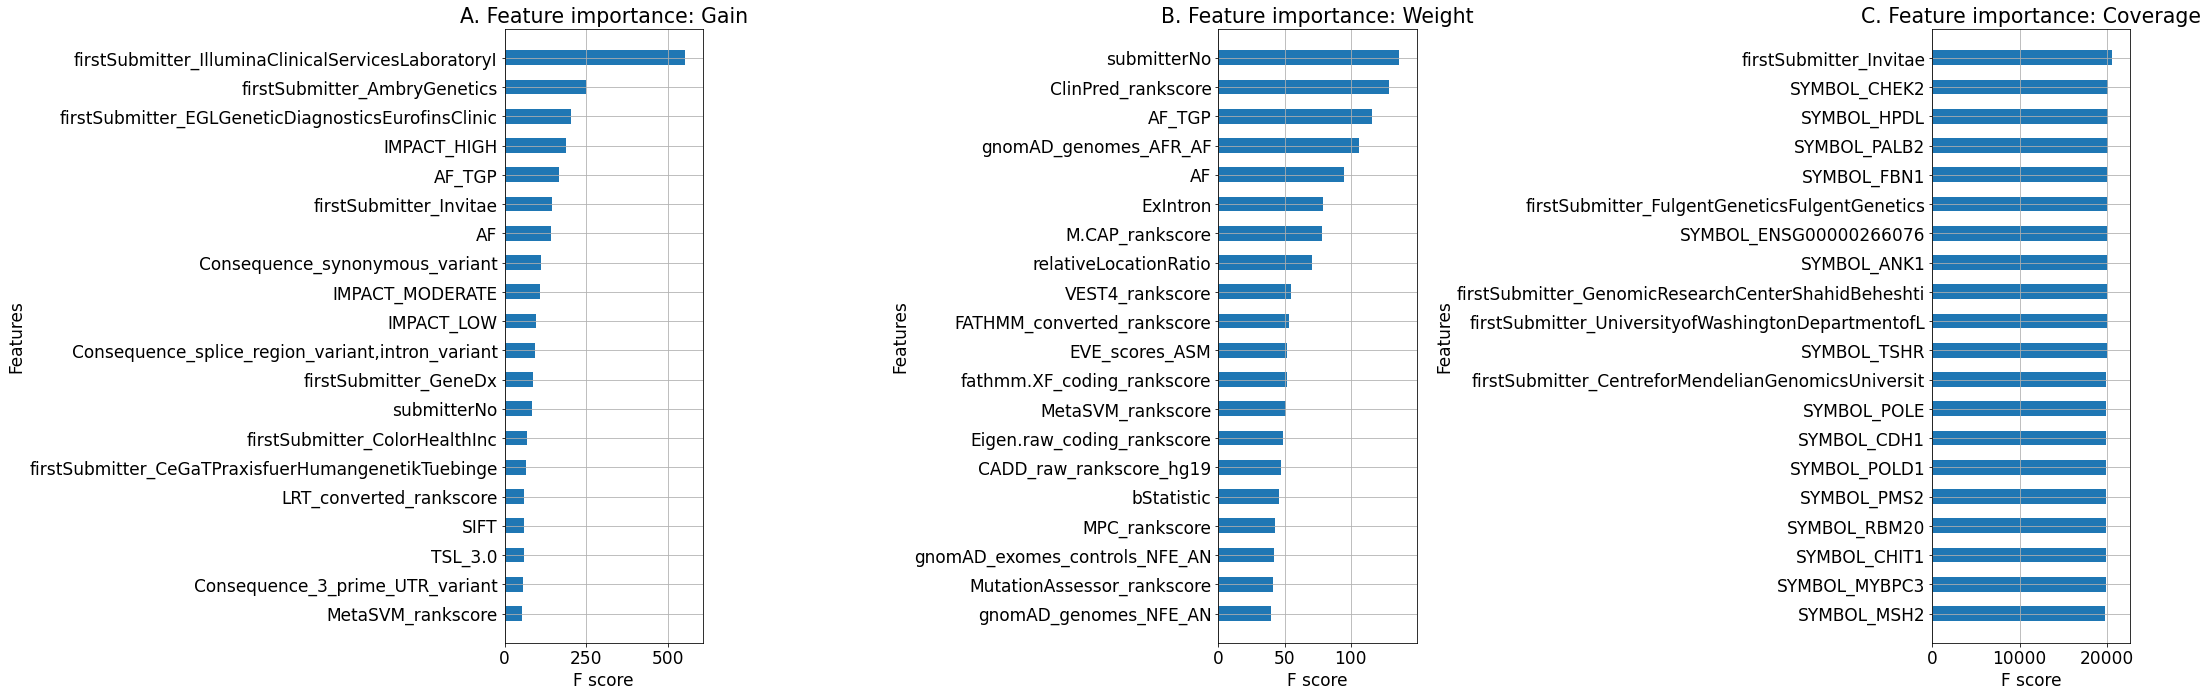

In [24]:
# Create the feature importances plot
# change font size
plt.rcParams.update({'font.size': 17})
# define panels
fig, ax = plt.subplots(1, 3, figsize=(30,10))
#plot importances with feature weight
xgb.plot_importance(
    booster=clf_xgb, 
    importance_type='weight',
    title='B. Feature importance: Weight',
    show_values=False,
    height=0.5,
    ax=ax[1],
    max_num_features=20
)
# plot importances with split mean gain
xgb.plot_importance(
    booster=clf_xgb,
    importance_type='gain',
    title='A. Feature importance: Gain',
    show_values=False,
    height=0.5,
    ax=ax[0],
    max_num_features=20
)
# plot importances with sample coverage
xgb.plot_importance(
    booster=clf_xgb,
    importance_type='cover',
    title='C. Feature importance: Coverage',
    show_values=False,
    height=0.5,
    ax=ax[2],
    max_num_features=20
)

# ax[0].set_title("A")
# ax[1].set_title("B")


plt.tight_layout()
#plt.savefig('feature_importance.svg',format='svg', bbox_inches='tight', dpi=800)
plt.show()

Figure ?. Feature importance plots from the optimized classifier. A. Gain plot indicates the relative contribution of the features to the model performance. A higher gain value of this metric is indicative of higher importance of a feature to make prediction. B. The weight plot indicates the percentage reflecting the relative number of times a given feature occurs in the booster trees. To calculate the weight for a given feature, the number of times that feature occurred at splits in all of the trees (n = 500) is counted and then divided by number weight of all other features. We expect to see numerical features (with numerous possible values) to show higher weight as compared to the binary features (two possible values). C. The coverage plot is showing the relative number of observations related to a given feature in the model. The length of each bar is proportional to number of times that a given feature was used to decide the leaf nodes in all the trees (n = 500 trees). Here we show top 20 features in each of the sub-plots.

## Finalized models

Finalize a model by applying the chosen machine learning procedure on all of the  data. In our case, we will run XGBoost with optimized hyperprametr on all of the data that we got: train + test + validation

In [30]:
# data preparing: providig all data to one hot coidn and y.
df = pd.read_csv("finalClin_3.csv", encoding='latin-1')
vdf = pd.read_csv("val_df.csv", encoding='latin-1')
l = [df,vdf]
df = pd.concat(l, ignore_index = True)

In [31]:
#defining x an y
# dropping columns
df = df.drop(['ID', 'Protein_position', 'Codons'], axis = 1).copy()

print("defining the target variables and predictors")
X = df.drop('class', axis = 1).copy()
X.head()

y = df['class'].copy()
y.head()


print("One-Hot Encoding")
X_encoded = pd.get_dummies(X, columns=['SYMBOL',
                                       'Allele',
                                       'CLNVC',
                                       'Consequence',
                                       'IMPACT',
                                       'CollectionMethod',
                                       'Denisova',
                                       'TSL',
                                       'firstSubmitter'])
X_encoded.head()

defining the target variables and predictors
One-Hot Encoding


,relativeLocationRatio,ExIntron,SIFT,PolyPhen,submitterNo,CADD_raw_rankscore_hg19,ClinPred_rankscore,DANN_rankscore,Eigen.raw_coding_rankscore,LIST.S2_rankscore,...,firstSubmitter_UNCMolecularGeneticsLaboratoryUnive,firstSubmitter_UWHindbrainMalformationResearchProg,firstSubmitter_UndiagnosedDiseasesNetworkNIH,firstSubmitter_UnitforGeneticEpidemiologicalResear,firstSubmitter_UniversityofWashingtonCenterforMend,firstSubmitter_UniversityofWashingtonDepartmentofL,firstSubmitter_VictorianClinicalGeneticsServicesMu,firstSubmitter_WomensHealthandGeneticsLaboratoryCo,firstSubmitter_WongMitoLabMolecularandHumanGenetic,firstSubmitter_other
0,1.000000,2.0,0.10,0.952,2,0.38964,0.15687,0.89085,0.38367,0.33984,...,0,0,0,0,0,0,0,0,0,0
1,1.000000,2.0,0.38,0.003,3,0.06002,0.00038,0.15196,0.03563,0.14579,...,0,0,0,0,0,0,0,0,0,0
2,1.000000,2.0,0.13,0.115,2,0.15404,0.19137,0.44442,0.16641,0.34650,...,0,0,0,0,0,0,0,0,0,0
3,1.000000,2.0,0.87,0.001,2,0.00104,0.00179,0.11246,0.00039,0.12095,...,0,0,0,0,0,0,0,0,0,0
4,0.027778,1.0,0.12,0.000,2,0.12689,0.00050,0.00769,0.02306,0.05533,...,0,0,0,0,0,0,0,0,0,0


In [32]:
#final mode-1
#fINALIZED Classifer based on hyperopt library
clf_xgb = xgb.XGBClassifier(seed=42,
                            objective = 'binary:logistic',
                            gamma = 3.65,
                            reg_lambda = 6.219,
                            learning_rate = 0.246,
                            max_depth = 6,
                            scale_pos_weight =  1.22,
                            subsample = 0.9,
                            colsample_bytree = 0.5,
                            n_estimators=500,
                            use_label_encoder=False)
# # define the eval set and metric
eval_set = [(X_test, y_test)]
eval_metric = ["aucpr","error"]


clf_xgb.fit(X_encoded,
            y,
            verbose = True,
            early_stopping_rounds  =10, eval_set = eval_set, eval_metric = eval_metric)

[0]	validation_0-aucpr:0.51536	validation_0-error:0.23081
[1]	validation_0-aucpr:0.59439	validation_0-error:0.20280
[2]	validation_0-aucpr:0.62923	validation_0-error:0.19879
[3]	validation_0-aucpr:0.63206	validation_0-error:0.19574
[4]	validation_0-aucpr:0.63300	validation_0-error:0.19420
[5]	validation_0-aucpr:0.63507	validation_0-error:0.19979
[6]	validation_0-aucpr:0.63697	validation_0-error:0.19962
[7]	validation_0-aucpr:0.64675	validation_0-error:0.19273
[8]	validation_0-aucpr:0.64994	validation_0-error:0.19247
[9]	validation_0-aucpr:0.65209	validation_0-error:0.19247
[10]	validation_0-aucpr:0.65361	validation_0-error:0.19196
[11]	validation_0-aucpr:0.65586	validation_0-error:0.19207
[12]	validation_0-aucpr:0.65764	validation_0-error:0.19111
[13]	validation_0-aucpr:0.66448	validation_0-error:0.19028
[14]	validation_0-aucpr:0.66764	validation_0-error:0.18972
[15]	validation_0-aucpr:0.67178	validation_0-error:0.18946
[16]	validation_0-aucpr:0.67417	validation_0-error:0.18925
[17]	va

[139]	validation_0-aucpr:0.72540	validation_0-error:0.17163
[140]	validation_0-aucpr:0.72548	validation_0-error:0.17161
[141]	validation_0-aucpr:0.72574	validation_0-error:0.17146
[142]	validation_0-aucpr:0.72580	validation_0-error:0.17135
[143]	validation_0-aucpr:0.72607	validation_0-error:0.17146
[144]	validation_0-aucpr:0.72614	validation_0-error:0.17155
[145]	validation_0-aucpr:0.72634	validation_0-error:0.17125
[146]	validation_0-aucpr:0.72668	validation_0-error:0.17116
[147]	validation_0-aucpr:0.72678	validation_0-error:0.17112
[148]	validation_0-aucpr:0.72701	validation_0-error:0.17105
[149]	validation_0-aucpr:0.72742	validation_0-error:0.17095
[150]	validation_0-aucpr:0.72762	validation_0-error:0.17095
[151]	validation_0-aucpr:0.72760	validation_0-error:0.17097
[152]	validation_0-aucpr:0.72778	validation_0-error:0.17103
[153]	validation_0-aucpr:0.72784	validation_0-error:0.17114
[154]	validation_0-aucpr:0.72789	validation_0-error:0.17125
[155]	validation_0-aucpr:0.72796	validat

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=3.65, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.246, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=16, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=6.219, scale_pos_weight=1.22, seed=42,
              subsample=0.9, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [33]:
#final mode-2
#fINALIZED Classifer based on hyperopt library
clf_xgb_2 = xgb.XGBClassifier(seed=42,
                            objective = 'binary:logistic',
                            gamma = 3.65,
                            reg_lambda = 6.219,
                            learning_rate = 0.246,
                            max_depth = 6,
                            scale_pos_weight =  5,
                            subsample = 0.9,
                            colsample_bytree = 0.5,
                            n_estimators=500,
                            use_label_encoder=False)
# # define the eval set and metric
eval_set = [(X_test, y_test)]
eval_metric = ["aucpr","error"]


clf_xgb_2.fit(X_encoded,
            y,
            verbose = True,
            early_stopping_rounds  =10, eval_set = eval_set, eval_metric = eval_metric)

[0]	validation_0-aucpr:0.48678	validation_0-error:0.47645
[1]	validation_0-aucpr:0.56446	validation_0-error:0.47935
[2]	validation_0-aucpr:0.61225	validation_0-error:0.43982
[3]	validation_0-aucpr:0.61567	validation_0-error:0.43393
[4]	validation_0-aucpr:0.62007	validation_0-error:0.41853
[5]	validation_0-aucpr:0.62280	validation_0-error:0.40210
[6]	validation_0-aucpr:0.62639	validation_0-error:0.40837
[7]	validation_0-aucpr:0.63669	validation_0-error:0.39694
[8]	validation_0-aucpr:0.64454	validation_0-error:0.38714
[9]	validation_0-aucpr:0.64586	validation_0-error:0.39237
[10]	validation_0-aucpr:0.64704	validation_0-error:0.38921
[11]	validation_0-aucpr:0.64867	validation_0-error:0.38988
[12]	validation_0-aucpr:0.64991	validation_0-error:0.38228
[13]	validation_0-aucpr:0.65945	validation_0-error:0.36777
[14]	validation_0-aucpr:0.66125	validation_0-error:0.35517
[15]	validation_0-aucpr:0.66566	validation_0-error:0.35190
[16]	validation_0-aucpr:0.66848	validation_0-error:0.34819
[17]	va

[139]	validation_0-aucpr:0.72239	validation_0-error:0.29076
[140]	validation_0-aucpr:0.72258	validation_0-error:0.29065
[141]	validation_0-aucpr:0.72302	validation_0-error:0.29040
[142]	validation_0-aucpr:0.72310	validation_0-error:0.29044
[143]	validation_0-aucpr:0.72328	validation_0-error:0.29012
[144]	validation_0-aucpr:0.72334	validation_0-error:0.28997
[145]	validation_0-aucpr:0.72381	validation_0-error:0.29012
[146]	validation_0-aucpr:0.72429	validation_0-error:0.28969
[147]	validation_0-aucpr:0.72456	validation_0-error:0.28920
[148]	validation_0-aucpr:0.72474	validation_0-error:0.28899
[149]	validation_0-aucpr:0.72530	validation_0-error:0.28918
[150]	validation_0-aucpr:0.72548	validation_0-error:0.28888
[151]	validation_0-aucpr:0.72557	validation_0-error:0.28884
[152]	validation_0-aucpr:0.72574	validation_0-error:0.28860
[153]	validation_0-aucpr:0.72577	validation_0-error:0.28852
[154]	validation_0-aucpr:0.72623	validation_0-error:0.28833
[155]	validation_0-aucpr:0.72625	validat

[276]	validation_0-aucpr:0.74562	validation_0-error:0.27036
[277]	validation_0-aucpr:0.74598	validation_0-error:0.27017
[278]	validation_0-aucpr:0.74608	validation_0-error:0.27032
[279]	validation_0-aucpr:0.74614	validation_0-error:0.27032
[280]	validation_0-aucpr:0.74636	validation_0-error:0.27004
[281]	validation_0-aucpr:0.74669	validation_0-error:0.26917
[282]	validation_0-aucpr:0.74677	validation_0-error:0.26919
[283]	validation_0-aucpr:0.74682	validation_0-error:0.26915
[284]	validation_0-aucpr:0.74687	validation_0-error:0.26936
[285]	validation_0-aucpr:0.74694	validation_0-error:0.26936
[286]	validation_0-aucpr:0.74701	validation_0-error:0.26887
[287]	validation_0-aucpr:0.74712	validation_0-error:0.26883
[288]	validation_0-aucpr:0.74723	validation_0-error:0.26872
[289]	validation_0-aucpr:0.74742	validation_0-error:0.26851
[290]	validation_0-aucpr:0.74745	validation_0-error:0.26857
[291]	validation_0-aucpr:0.74755	validation_0-error:0.26853
[292]	validation_0-aucpr:0.74764	validat

[413]	validation_0-aucpr:0.76143	validation_0-error:0.25760
[414]	validation_0-aucpr:0.76153	validation_0-error:0.25780
[415]	validation_0-aucpr:0.76160	validation_0-error:0.25778
[416]	validation_0-aucpr:0.76165	validation_0-error:0.25769
[417]	validation_0-aucpr:0.76189	validation_0-error:0.25756
[418]	validation_0-aucpr:0.76189	validation_0-error:0.25744
[419]	validation_0-aucpr:0.76191	validation_0-error:0.25758
[420]	validation_0-aucpr:0.76201	validation_0-error:0.25735
[421]	validation_0-aucpr:0.76202	validation_0-error:0.25731
[422]	validation_0-aucpr:0.76229	validation_0-error:0.25709
[423]	validation_0-aucpr:0.76234	validation_0-error:0.25705
[424]	validation_0-aucpr:0.76238	validation_0-error:0.25692
[425]	validation_0-aucpr:0.76250	validation_0-error:0.25654
[426]	validation_0-aucpr:0.76292	validation_0-error:0.25616
[427]	validation_0-aucpr:0.76294	validation_0-error:0.25613
[428]	validation_0-aucpr:0.76306	validation_0-error:0.25605
[429]	validation_0-aucpr:0.76309	validat

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=3.65, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.246, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=16, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=6.219, scale_pos_weight=5, seed=42,
              subsample=0.9, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [34]:
#final mode-3
#fINALIZED Classifer based on hyperopt library
clf_xgb_3 = xgb.XGBClassifier(seed=42,
                            objective = 'binary:logistic',
                            gamma = 3.65,
                            reg_lambda = 6.219,
                            learning_rate = 0.246,
                            max_depth = 6,
                            scale_pos_weight =  3,
                            subsample = 0.9,
                            colsample_bytree = 0.5,
                            n_estimators=500,
                            use_label_encoder=False)
# # define the eval set and metric
eval_set = [(X_test, y_test)]
eval_metric = ["aucpr","error"]


clf_xgb_3.fit(X_encoded,
            y,
            verbose = True,
            early_stopping_rounds  =10, eval_set = eval_set, eval_metric = eval_metric)

[0]	validation_0-aucpr:0.49991	validation_0-error:0.31438
[1]	validation_0-aucpr:0.57276	validation_0-error:0.28694
[2]	validation_0-aucpr:0.61448	validation_0-error:0.25298
[3]	validation_0-aucpr:0.62048	validation_0-error:0.25310
[4]	validation_0-aucpr:0.62508	validation_0-error:0.25472
[5]	validation_0-aucpr:0.62639	validation_0-error:0.25287
[6]	validation_0-aucpr:0.62815	validation_0-error:0.25195
[7]	validation_0-aucpr:0.63867	validation_0-error:0.25063
[8]	validation_0-aucpr:0.64123	validation_0-error:0.25639
[9]	validation_0-aucpr:0.64372	validation_0-error:0.25197
[10]	validation_0-aucpr:0.64402	validation_0-error:0.25737
[11]	validation_0-aucpr:0.64579	validation_0-error:0.25573
[12]	validation_0-aucpr:0.64705	validation_0-error:0.25660
[13]	validation_0-aucpr:0.65656	validation_0-error:0.25351
[14]	validation_0-aucpr:0.66110	validation_0-error:0.24805
[15]	validation_0-aucpr:0.66469	validation_0-error:0.24724
[16]	validation_0-aucpr:0.66824	validation_0-error:0.24822
[17]	va

[139]	validation_0-aucpr:0.72394	validation_0-error:0.21937
[140]	validation_0-aucpr:0.72397	validation_0-error:0.21933
[141]	validation_0-aucpr:0.72418	validation_0-error:0.21921
[142]	validation_0-aucpr:0.72431	validation_0-error:0.21903
[143]	validation_0-aucpr:0.72444	validation_0-error:0.21927
[144]	validation_0-aucpr:0.72448	validation_0-error:0.21935
[145]	validation_0-aucpr:0.72477	validation_0-error:0.21935
[146]	validation_0-aucpr:0.72505	validation_0-error:0.21940
[147]	validation_0-aucpr:0.72537	validation_0-error:0.21927
[148]	validation_0-aucpr:0.72562	validation_0-error:0.21910
[149]	validation_0-aucpr:0.72592	validation_0-error:0.21897
[150]	validation_0-aucpr:0.72600	validation_0-error:0.21899
[151]	validation_0-aucpr:0.72616	validation_0-error:0.21891
[152]	validation_0-aucpr:0.72629	validation_0-error:0.21874
[153]	validation_0-aucpr:0.72641	validation_0-error:0.21869
[154]	validation_0-aucpr:0.72687	validation_0-error:0.21822
[155]	validation_0-aucpr:0.72708	validat

[276]	validation_0-aucpr:0.74759	validation_0-error:0.20619
[277]	validation_0-aucpr:0.74789	validation_0-error:0.20638
[278]	validation_0-aucpr:0.74827	validation_0-error:0.20632
[279]	validation_0-aucpr:0.74833	validation_0-error:0.20636
[280]	validation_0-aucpr:0.74871	validation_0-error:0.20568
[281]	validation_0-aucpr:0.74927	validation_0-error:0.20551
[282]	validation_0-aucpr:0.74935	validation_0-error:0.20542
[283]	validation_0-aucpr:0.74938	validation_0-error:0.20544
[284]	validation_0-aucpr:0.74941	validation_0-error:0.20542
[285]	validation_0-aucpr:0.74950	validation_0-error:0.20536
[286]	validation_0-aucpr:0.74960	validation_0-error:0.20538
[287]	validation_0-aucpr:0.74960	validation_0-error:0.20534
[288]	validation_0-aucpr:0.74971	validation_0-error:0.20534
[289]	validation_0-aucpr:0.74985	validation_0-error:0.20544
[290]	validation_0-aucpr:0.75011	validation_0-error:0.20519
[291]	validation_0-aucpr:0.75024	validation_0-error:0.20523
[292]	validation_0-aucpr:0.75030	validat

[413]	validation_0-aucpr:0.76416	validation_0-error:0.19582
[414]	validation_0-aucpr:0.76433	validation_0-error:0.19550
[415]	validation_0-aucpr:0.76437	validation_0-error:0.19550
[416]	validation_0-aucpr:0.76436	validation_0-error:0.19537
[417]	validation_0-aucpr:0.76448	validation_0-error:0.19546
[418]	validation_0-aucpr:0.76446	validation_0-error:0.19548
[419]	validation_0-aucpr:0.76448	validation_0-error:0.19561
[420]	validation_0-aucpr:0.76449	validation_0-error:0.19555
[421]	validation_0-aucpr:0.76455	validation_0-error:0.19548
[422]	validation_0-aucpr:0.76455	validation_0-error:0.19548
[423]	validation_0-aucpr:0.76458	validation_0-error:0.19529
[424]	validation_0-aucpr:0.76460	validation_0-error:0.19535
[425]	validation_0-aucpr:0.76475	validation_0-error:0.19520
[426]	validation_0-aucpr:0.76510	validation_0-error:0.19503
[427]	validation_0-aucpr:0.76516	validation_0-error:0.19503
[428]	validation_0-aucpr:0.76518	validation_0-error:0.19497
[429]	validation_0-aucpr:0.76520	validat

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=3.65, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.246, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=16, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=6.219, scale_pos_weight=3, seed=42,
              subsample=0.9, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

## Save the classifier

In [45]:
# number of trees
clf_xgb_2.best_ntree_limit


500

In [146]:
# saving
# save in JSON format
# the following file is the best optimized model
#clf_xgb.save_model("final_model_1.json")
#clf_xgb_2.save_model("final_model_3.json")
#clf_xgb_3.save_model("final_model_2.json")


### Running on the production set (single-submitter)

In [37]:
# due to memory limitation, single-submitter fils should be splitted into smaller data
#
sX.shape

(690455, 4123)

In [53]:
# model_1
model_1_prediction_1 = clf_xgb.predict(sX.iloc[:300000])
model_1_prediction_2 = clf_xgb.predict(sX.iloc[300000:])
model_1_res = np.append(model_1_prediction_1, model_1_prediction_2, axis=None)

In [55]:
# model_2
model_2_prediction_1 = clf_xgb_2.predict(sX.iloc[:300000])
model_2_prediction_2 = clf_xgb_2.predict(sX.iloc[300000:])
model_2_res = np.append(model_2_prediction_1, model_2_prediction_2, axis=None)

In [64]:
# model_3
model_3_prediction_1 = clf_xgb_3.predict(sX.iloc[:300000])
model_3_prediction_2 = clf_xgb_3.predict(sX.iloc[300000:])
model_3_res = np.append(model_3_prediction_1, model_3_prediction_2, axis=None)

In [70]:
# Put all result and variant Ids into a dataframe
res = pd.DataFrame()
res['ID']= ss.loc[:, 'ID']
res['Model_1']=model_1_res
res['Model_2']=model_2_res
res['Model_3']=model_3_res
# saving 
res.to_csv('clinvar_conflict_pred.csv', index = False)